# Evaluation of Rate of Hospital Admission Related to Infections

In this notebook, we evaluate the rate of hospital admission related to common infections, including upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), urinary tract infection (UTI).

In [16]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from datetime import date
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [17]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit\analysis


In [18]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [19]:
def create_lineplot(data, var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq /1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [28]:
data_hosp_rate_all = pd.read_csv(f'../output/measures/input_hospitalisation_rate_2019-01-01.csv.gz')
data_hosp_rate_all.head()

,admitted_date,age,age_cat,sex,admitted,admitted_cat,gp_cons_admitted_binary,sgss_pos_covid_admitted_binary,gp_covid_date_admitted_binary,sgss_gp_cov_admitted_binary,patient_id
0,NaN,84,35-44,M,5,NaN,0,0,0,0,7638
1,NaN,20,0-4,M,5,NaN,0,1,1,1,4821
2,NaN,44,5-14,M,3,Streptococcal sepsis,0,0,1,0,6783
3,NaN,33,75+,F,0,Pneumonia due to Streptococcus pneumoniae,0,0,0,0,370
4,NaN,6,35-44,M,6,NaN,0,0,1,0,1154


In [29]:
data_hosp_rate_all.columns

Index(['admitted_date', 'age', 'age_cat', 'sex', 'admitted', 'admitted_cat',
       'gp_cons_admitted_binary', 'sgss_pos_covid_admitted_binary',
       'gp_covid_date_admitted_binary', 'sgss_gp_cov_admitted_binary',
       'patient_id'],
      dtype='object')

In [31]:
data_hosp_rate_all.admitted_date.value_counts()

2019-01-26    2
2019-01-11    1
2019-01-25    1
2019-01-28    1
2019-01-06    1
2019-01-10    1
Name: admitted_date, dtype: int64

In [32]:
data_hosp_rate_sex_age_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_sex_age_cat.csv')
data_hosp_rate_cat_sex_age_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_cat_sex_age_cat.csv')
data_hosp_rate_sex_age_cat_gp = pd.read_csv(f'../output/measures/measure_hosp_rate_sex_age_cat_gp.csv')

data_hosp_rate_sex_age_cat.head()#.shape

,sex,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0-4,0,163.0,56.0,2.910714,2019-01-01
1,F,0-4,1,47.0,8.0,5.875000,2019-01-01
2,F,15-24,0,122.0,50.0,2.440000,2019-01-01
3,F,15-24,1,11.0,NaN,NaN,2019-01-01
4,F,25-34,0,172.0,51.0,3.372549,2019-01-01


In [33]:
data_hosp_rate_sex_age_cat = data_hosp_rate_sex_age_cat[data_hosp_rate_sex_age_cat['sgss_gp_cov_admitted_binary']==0]
data_hosp_rate_cat_sex_age_cat = data_hosp_rate_cat_sex_age_cat[data_hosp_rate_cat_sex_age_cat['sgss_gp_cov_admitted_binary']==0]
data_hosp_rate_sex_age_cat_gp = data_hosp_rate_sex_age_cat_gp[data_hosp_rate_sex_age_cat_gp['sgss_gp_cov_admitted_binary']==0]

data_hosp_rate_sex_age_cat.head()#.shape

,sex,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0-4,0,163.0,56.0,2.910714,2019-01-01
2,F,15-24,0,122.0,50.0,2.440000,2019-01-01
4,F,25-34,0,172.0,51.0,3.372549,2019-01-01
6,F,35-44,0,179.0,46.0,3.891304,2019-01-01
8,F,45-54,0,160.0,53.0,3.018868,2019-01-01


In [43]:
# translate sex in data_hosp_rate_sex_age_cat
dict_sex = {'F': 'Female', 'M': 'Male'}
data_hosp_rate_sex_age_cat = data_hosp_rate_sex_age_cat.replace({"sex": dict_sex})

In [34]:
data_hosp_rate_sex_age_cat.describe(include='all')

,sex,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,684,684,684.0,684.000000,684.00000,684.000000,684
unique,2,9,NaN,NaN,NaN,NaN,38
top,F,0-4,NaN,NaN,NaN,NaN,2019-01-01
freq,342,76,NaN,NaN,NaN,NaN,18
mean,NaN,NaN,0.0,164.524854,50.00000,3.292371,NaN
std,NaN,NaN,0.0,34.308406,7.27196,0.513351,NaN
min,NaN,NaN,0.0,78.000000,30.00000,1.930233,NaN
25%,NaN,NaN,0.0,140.000000,45.00000,2.919592,NaN
50%,NaN,NaN,0.0,163.500000,50.00000,3.245614,NaN
75%,NaN,NaN,0.0,186.000000,55.00000,3.620000,NaN


In [35]:
data_hosp_rate_cat_sex_age_cat.describe(include='all')

,sex,age_cat,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,5472,5472,4788,5472.0,4774.000000,2194.000000,1093.000000,5472
unique,2,9,7,NaN,NaN,NaN,NaN,38
top,F,0-4,Meningitis in bacterial diseases classified el...,NaN,NaN,NaN,NaN,2019-01-01
freq,2736,608,684,NaN,NaN,NaN,NaN,144
mean,NaN,NaN,NaN,0.0,23.059698,12.241568,3.300517,NaN
std,NaN,NaN,NaN,0.0,39.853182,15.909055,0.934855,NaN
min,NaN,NaN,NaN,0.0,-2.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,0.0,0.000000,0.000000,2.727273,NaN
50%,NaN,NaN,NaN,0.0,8.000000,0.000000,3.234043,NaN
75%,NaN,NaN,NaN,0.0,19.000000,30.000000,3.828571,NaN


In [36]:
data_hosp_rate_sex_age_cat_gp.describe(include='all')

,sex,age_cat,gp_cons_admitted_binary,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,1368,1368,1368.000000,1368.0,1368.000000,1368.000000,1368.000000,1368
unique,2,9,NaN,NaN,NaN,NaN,NaN,38
top,F,0-4,NaN,NaN,NaN,NaN,NaN,2019-01-01
freq,684,152,NaN,NaN,NaN,NaN,NaN,36
mean,NaN,NaN,0.500000,0.0,82.262427,25.000000,3.291829,NaN
std,NaN,NaN,0.500183,0.0,23.584845,4.985568,0.709305,NaN
min,NaN,NaN,0.000000,0.0,15.000000,10.000000,1.250000,NaN
25%,NaN,NaN,0.000000,0.0,65.000000,21.000000,2.800000,NaN
50%,NaN,NaN,0.500000,0.0,81.000000,25.000000,3.266194,NaN
75%,NaN,NaN,1.000000,0.0,98.000000,28.000000,3.765196,NaN


## 2- Hospital admission rate

In [37]:
data_hosp_rate_sex_age_cat.isnull().sum()

sex                            0
age_cat                        0
sgss_gp_cov_admitted_binary    0
admitted                       0
population                     0
value                          0
date                           0
dtype: int64

In [38]:
data_hosp_rate_sex_age_cat_groupby_date = data_hosp_rate_sex_age_cat.groupby([data_hosp_rate_sex_age_cat['date']]).sum()
data_hosp_rate_sex_age_cat_groupby_date.head()

,sgss_gp_cov_admitted_binary,admitted,population,value
date,,,,
2019-01-01,0,2992.0,900.0,60.616388
2019-02-01,0,2945.0,900.0,58.932712
2019-03-01,0,2973.0,900.0,59.510004
2019-04-01,0,2981.0,900.0,59.668472
2019-05-01,0,2965.0,900.0,59.640804


In [39]:
data_hosp_rate_sex_age_cat_groupby_date['date'] = data_hosp_rate_sex_age_cat_groupby_date.index

data_hosp_rate_sex_age_cat_groupby_date.date = pd.to_datetime(data_hosp_rate_sex_age_cat_groupby_date.date)

data_hosp_rate_sex_age_cat_groupby_date.date = data_hosp_rate_sex_age_cat_groupby_date.date.dt.strftime('%Y-%m')

data_hosp_rate_sex_age_cat_groupby_date.index = data_hosp_rate_sex_age_cat_groupby_date.date

data_hosp_rate_sex_age_cat_groupby_date = data_hosp_rate_sex_age_cat_groupby_date.drop(columns=['date'])

data_hosp_rate_sex_age_cat_groupby_date.head()

,sgss_gp_cov_admitted_binary,admitted,population,value
date,,,,
2019-01,0,2992.0,900.0,60.616388
2019-02,0,2945.0,900.0,58.932712
2019-03,0,2973.0,900.0,59.510004
2019-04,0,2981.0,900.0,59.668472
2019-05,0,2965.0,900.0,59.640804


In [40]:
data_hosp_rate_sex_age_cat_groupby_date['value'] = data_hosp_rate_sex_age_cat_groupby_date['value']*1000

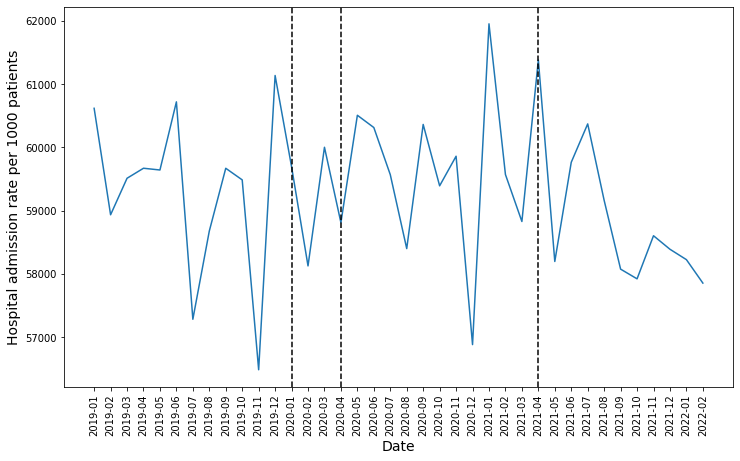

In [41]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(y=data_hosp_rate_sex_age_cat_groupby_date.value, x=data_hosp_rate_sex_age_cat_groupby_date.index, ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_1000_patient.jpg')
plt.show()

## 3- Hospital admission with sex

In [45]:
data_hosp_rate_sex_age_cat

,sex,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,Female,0-4,0,163.0,56.0,2.910714,2019-01-01
2,Female,15-24,0,122.0,50.0,2.440000,2019-01-01
4,Female,25-34,0,172.0,51.0,3.372549,2019-01-01
6,Female,35-44,0,179.0,46.0,3.891304,2019-01-01
8,Female,45-54,0,160.0,53.0,3.018868,2019-01-01
...,...,...,...,...,...,...,...
1358,Male,45-54,0,154.0,42.0,3.666667,2022-02-01
1360,Male,5-14,0,171.0,49.0,3.489796,2022-02-01
1362,Male,55-64,0,152.0,46.0,3.304348,2022-02-01
1364,Male,65-74,0,157.0,51.0,3.078431,2022-02-01


In [50]:
data_hosp_rate_cat_sex_age_cat_groupby_sex = data_hosp_rate_sex_age_cat.groupby(['date', 'sex']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_sex_age_cat_groupby_sex = data_hosp_rate_cat_sex_age_cat_groupby_sex.reset_index()
data_hosp_rate_cat_sex_age_cat_groupby_sex.columns = ['date', 'sex', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_sex_age_cat_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01-01,Female,3.202632,2.440000,4.250000,28.823687
1,2019-01-01,Male,3.532522,2.918033,4.725000,31.792701
2,2019-02-01,Female,3.315968,2.770833,3.836735,29.843711
3,2019-02-01,Male,3.232111,2.437500,4.181818,29.089001
4,2019-03-01,Female,3.419511,2.525424,4.072727,30.775599


In [51]:
# data_hosp_rate_cat_sex_age_cat_groupby_sex['date'] = data_hosp_rate_cat_sex_age_cat_groupby_sex.index

data_hosp_rate_cat_sex_age_cat_groupby_sex.date = pd.to_datetime(data_hosp_rate_cat_sex_age_cat_groupby_sex.date)

data_hosp_rate_cat_sex_age_cat_groupby_sex.date = data_hosp_rate_cat_sex_age_cat_groupby_sex.date.dt.strftime('%Y-%m')

# data_hosp_rate_cat_sex_age_cat_groupby_sex.index = data_hosp_rate_cat_sex_age_cat_groupby_sex.date

# data_hosp_rate_cat_sex_age_cat_groupby_sex = data_hosp_rate_cat_sex_age_cat_groupby_sex.drop(columns=['date'])

data_hosp_rate_cat_sex_age_cat_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01,Female,3.202632,2.440000,4.250000,28.823687
1,2019-01,Male,3.532522,2.918033,4.725000,31.792701
2,2019-02,Female,3.315968,2.770833,3.836735,29.843711
3,2019-02,Male,3.232111,2.437500,4.181818,29.089001
4,2019-03,Female,3.419511,2.525424,4.072727,30.775599


In [52]:
data_hosp_rate_cat_sex_age_cat_groupby_sex['value_sum'] = data_hosp_rate_cat_sex_age_cat_groupby_sex['value_sum']*1000

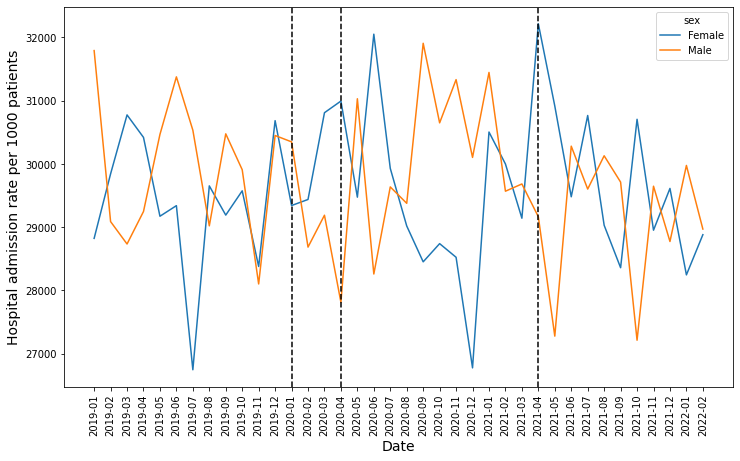

In [57]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_age_cat_groupby_sex, y="value_sum", x="date", hue="sex", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient.jpg')
plt.show()

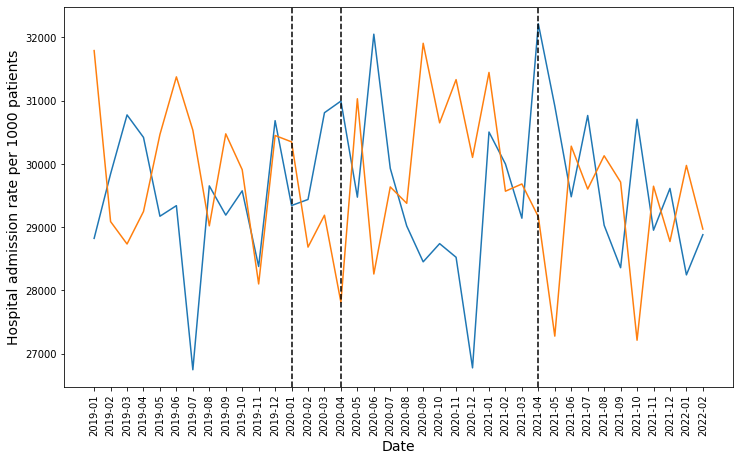

In [56]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_age_cat_groupby_sex, y="value_sum", x="date", hue="sex", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient_nolegend.jpg')
plt.show()

## 4- Hospital admission with age_cat

In [58]:
data_hosp_rate_sex_age_cat

,sex,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,Female,0-4,0,163.0,56.0,2.910714,2019-01-01
2,Female,15-24,0,122.0,50.0,2.440000,2019-01-01
4,Female,25-34,0,172.0,51.0,3.372549,2019-01-01
6,Female,35-44,0,179.0,46.0,3.891304,2019-01-01
8,Female,45-54,0,160.0,53.0,3.018868,2019-01-01
...,...,...,...,...,...,...,...
1358,Male,45-54,0,154.0,42.0,3.666667,2022-02-01
1360,Male,5-14,0,171.0,49.0,3.489796,2022-02-01
1362,Male,55-64,0,152.0,46.0,3.304348,2022-02-01
1364,Male,65-74,0,157.0,51.0,3.078431,2022-02-01


In [59]:
data_hosp_rate_cat_sex_age_cat_groupby_age = data_hosp_rate_sex_age_cat.groupby(['date', 'age_cat']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_sex_age_cat_groupby_age = data_hosp_rate_cat_sex_age_cat_groupby_age.reset_index()
data_hosp_rate_cat_sex_age_cat_groupby_age.columns = ['date', 'age', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_sex_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01-01,0-4,3.817857,2.910714,4.725000,7.635714
1,2019-01-01,15-24,3.275556,2.440000,4.111111,6.551111
2,2019-01-01,25-34,3.400560,3.372549,3.428571,6.801120
3,2019-01-01,35-44,3.582016,3.272727,3.891304,7.164032
4,2019-01-01,45-54,2.985624,2.952381,3.018868,5.971249


In [60]:
# data_hosp_rate_cat_sex_age_cat_groupby_age['date'] = data_hosp_rate_cat_sex_age_cat_groupby_age.index

data_hosp_rate_cat_sex_age_cat_groupby_age.date = pd.to_datetime(data_hosp_rate_cat_sex_age_cat_groupby_age.date)

data_hosp_rate_cat_sex_age_cat_groupby_age.date = data_hosp_rate_cat_sex_age_cat_groupby_age.date.dt.strftime('%Y-%m')

# data_hosp_rate_cat_sex_age_cat_groupby_age.index = data_hosp_rate_cat_sex_age_cat_groupby_age.date

# data_hosp_rate_cat_sex_age_cat_groupby_age = data_hosp_rate_cat_sex_age_cat_groupby_age.drop(columns=['date'])

data_hosp_rate_cat_sex_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01,0-4,3.817857,2.910714,4.725000,7.635714
1,2019-01,15-24,3.275556,2.440000,4.111111,6.551111
2,2019-01,25-34,3.400560,3.372549,3.428571,6.801120
3,2019-01,35-44,3.582016,3.272727,3.891304,7.164032
4,2019-01,45-54,2.985624,2.952381,3.018868,5.971249


In [61]:
data_hosp_rate_cat_sex_age_cat_groupby_age['value_sum'] = data_hosp_rate_cat_sex_age_cat_groupby_age['value_sum']*1000

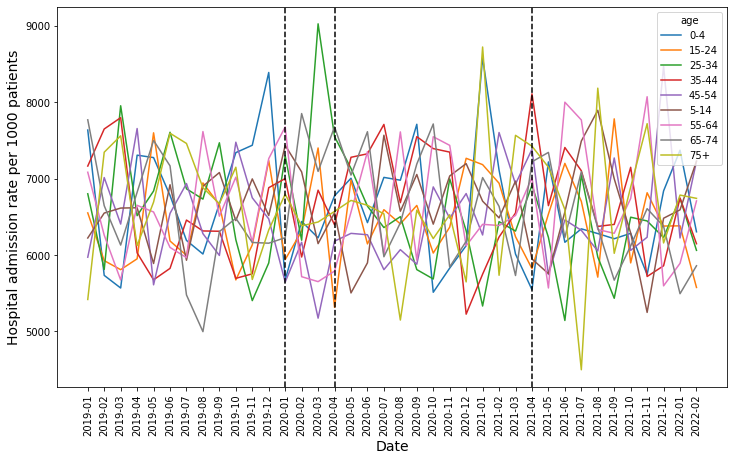

In [63]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_age_cat_groupby_age, y="value_sum", x="date", hue="age", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient.jpg')
plt.show()

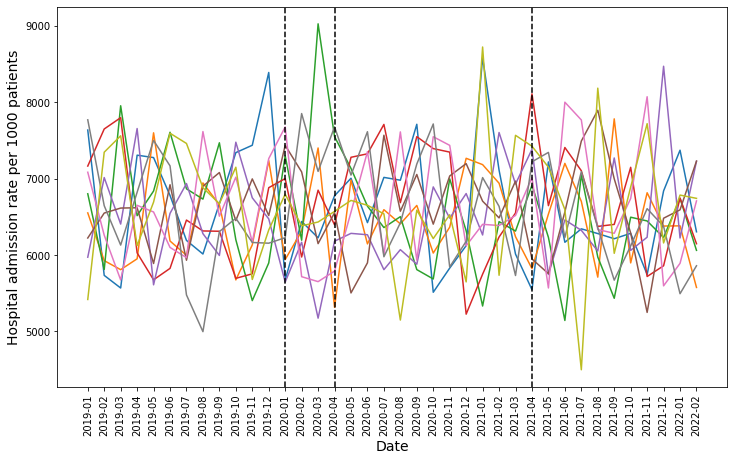

In [64]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_age_cat_groupby_age, y="value_sum", x="date", hue="age", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient_nolegend.jpg')
plt.show()

## 5- Hospital admission with category

In [39]:
data_hosp_rate_cat_sex_age_cat.head()

,sex,age_cat,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0-4,NaN,0,102.0,30.0,3.4,2019-01-01
1,F,0-4,NaN,1,23.0,NaN,NaN,2019-01-01
2,F,0-4,Meningitis in bacterial diseases classified el...,0,0.0,NaN,NaN,2019-01-01
3,F,0-4,Meningitis in bacterial diseases classified el...,1,0.0,0.0,NaN,2019-01-01
4,F,0-4,Other sepsis,0,0.0,NaN,NaN,2019-01-01


In [40]:
data_hosp_rate_cat_sex_age_cat.shape

(10944, 8)

In [41]:
data_hosp_rate_cat_sex_age_cat.isnull().sum()

sex                               0
age_cat                           0
admitted_cat                   1368
sgss_gp_cov_admitted_binary       0
admitted                       1053
population                     4754
value                          9717
date                              0
dtype: int64

In [42]:
#drop rows with missing values
# data_hosp_rate_cat_sex_age_cat = data_hosp_rate_cat_sex_age_cat.dropna(axis='rows')
print(f'shape of data_hosp_rate_cat_sex_age_cat: {data_hosp_rate_cat_sex_age_cat.shape}\n')
data_hosp_rate_cat_sex_age_cat.head()

shape of data_hosp_rate_cat_sex_age_cat: (10944, 8)



,sex,age_cat,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0-4,NaN,0,102.0,30.0,3.4,2019-01-01
1,F,0-4,NaN,1,23.0,NaN,NaN,2019-01-01
2,F,0-4,Meningitis in bacterial diseases classified el...,0,0.0,NaN,NaN,2019-01-01
3,F,0-4,Meningitis in bacterial diseases classified el...,1,0.0,0.0,NaN,2019-01-01
4,F,0-4,Other sepsis,0,0.0,NaN,NaN,2019-01-01


In [43]:
data_hosp_rate_cat_sex_age_cat_groupby_date = data_hosp_rate_cat_sex_age_cat.groupby([data_hosp_rate_cat_sex_age_cat['date']]).sum()
data_hosp_rate_cat_sex_age_cat_groupby_date.head()

,sgss_gp_cov_admitted_binary,admitted,population,value
date,,,,
2019-01-01,144,3282.0,705.0,98.425288
2019-02-01,144,3149.0,753.0,118.718299
2019-03-01,144,3279.0,755.0,119.561576
2019-04-01,144,3239.0,740.0,104.876652
2019-05-01,144,3323.0,708.0,99.081020


In [44]:
data_hosp_rate_cat_sex_age_cat_groupby_date = data_hosp_rate_cat_sex_age_cat.groupby(['date', 'admitted_cat']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_sex_age_cat_groupby_date = data_hosp_rate_cat_sex_age_cat_groupby_date.reset_index()
data_hosp_rate_cat_sex_age_cat_groupby_date.columns = ['date', 'admitted_cat', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_sex_age_cat_groupby_date

,date,admitted_cat,value_mean,value_min,value_max,value_sum
0,2019-01-01,Meningitis in bacterial diseases classified el...,NaN,NaN,NaN,0.000000
1,2019-01-01,Other sepsis,NaN,NaN,NaN,0.000000
2,2019-01-01,Pneumonia due to Haemophilus influenzae,NaN,NaN,NaN,0.000000
3,2019-01-01,Pneumonia due to Streptococcus pneumoniae,NaN,NaN,NaN,0.000000
4,2019-01-01,Pneumonia in diseases classified elsewhere,3.601190,1.571429,6.833333,14.404762
...,...,...,...,...,...,...
261,2022-02-01,Pneumonia due to Haemophilus influenzae,NaN,NaN,NaN,0.000000
262,2022-02-01,Pneumonia due to Streptococcus pneumoniae,NaN,NaN,NaN,0.000000
263,2022-02-01,Pneumonia in diseases classified elsewhere,2.747166,1.714286,4.333333,19.230159
264,2022-02-01,Streptococcal sepsis,NaN,NaN,NaN,0.000000


In [45]:
# data_hosp_rate_cat_sex_age_cat_groupby_date['date'] = data_hosp_rate_cat_sex_age_cat_groupby_date.index

data_hosp_rate_cat_sex_age_cat_groupby_date.date = pd.to_datetime(data_hosp_rate_cat_sex_age_cat_groupby_date.date)

data_hosp_rate_cat_sex_age_cat_groupby_date.date = data_hosp_rate_cat_sex_age_cat_groupby_date.date.dt.strftime('%Y-%m')

# data_hosp_rate_cat_sex_age_cat_groupby_date.index = data_hosp_rate_cat_sex_age_cat_groupby_date.date

# data_hosp_rate_cat_sex_age_cat_groupby_date = data_hosp_rate_cat_sex_age_cat_groupby_date.drop(columns=['date'])

data_hosp_rate_cat_sex_age_cat_groupby_date.head()

,date,admitted_cat,value_mean,value_min,value_max,value_sum
0,2019-01,Meningitis in bacterial diseases classified el...,NaN,NaN,NaN,0.000000
1,2019-01,Other sepsis,NaN,NaN,NaN,0.000000
2,2019-01,Pneumonia due to Haemophilus influenzae,NaN,NaN,NaN,0.000000
3,2019-01,Pneumonia due to Streptococcus pneumoniae,NaN,NaN,NaN,0.000000
4,2019-01,Pneumonia in diseases classified elsewhere,3.60119,1.571429,6.833333,14.404762


In [46]:
data_hosp_rate_cat_sex_age_cat_groupby_date#.shape

,date,admitted_cat,value_mean,value_min,value_max,value_sum
0,2019-01,Meningitis in bacterial diseases classified el...,NaN,NaN,NaN,0.000000
1,2019-01,Other sepsis,NaN,NaN,NaN,0.000000
2,2019-01,Pneumonia due to Haemophilus influenzae,NaN,NaN,NaN,0.000000
3,2019-01,Pneumonia due to Streptococcus pneumoniae,NaN,NaN,NaN,0.000000
4,2019-01,Pneumonia in diseases classified elsewhere,3.601190,1.571429,6.833333,14.404762
...,...,...,...,...,...,...
261,2022-02,Pneumonia due to Haemophilus influenzae,NaN,NaN,NaN,0.000000
262,2022-02,Pneumonia due to Streptococcus pneumoniae,NaN,NaN,NaN,0.000000
263,2022-02,Pneumonia in diseases classified elsewhere,2.747166,1.714286,4.333333,19.230159
264,2022-02,Streptococcal sepsis,NaN,NaN,NaN,0.000000


In [47]:
data_hosp_rate_cat_sex_age_cat_groupby_date['admitted_cat'].value_counts()#.iloc[:4].rename_axis('val').reset_index(name='count')

Meningitis in bacterial diseases classified elsewhere    38
Other sepsis                                             38
Pneumonia due to Haemophilus influenzae                  38
Pneumonia due to Streptococcus pneumoniae                38
Pneumonia in diseases classified elsewhere               38
Streptococcal sepsis                                     38
ot_externa                                               38
Name: admitted_cat, dtype: int64

In [48]:
data_hosp_rate_cat_sex_age_cat_groupby_date.groupby(['date', 'admitted_cat']).count().reset_index()

,date,admitted_cat,value_mean,value_min,value_max,value_sum
0,2019-01,Meningitis in bacterial diseases classified el...,0,0,0,1
1,2019-01,Other sepsis,0,0,0,1
2,2019-01,Pneumonia due to Haemophilus influenzae,0,0,0,1
3,2019-01,Pneumonia due to Streptococcus pneumoniae,0,0,0,1
4,2019-01,Pneumonia in diseases classified elsewhere,1,1,1,1
...,...,...,...,...,...,...
261,2022-02,Pneumonia due to Haemophilus influenzae,0,0,0,1
262,2022-02,Pneumonia due to Streptococcus pneumoniae,0,0,0,1
263,2022-02,Pneumonia in diseases classified elsewhere,1,1,1,1
264,2022-02,Streptococcal sepsis,0,0,0,1


In [50]:
data_hosp_rate_cat_sex_age_cat_groupby_date = data_hosp_rate_cat_sex_age_cat_groupby_date[data_hosp_rate_cat_sex_age_cat_groupby_date.groupby('admitted_cat')['admitted_cat'].transform('count').ge(38)]

,date,admitted_cat,value_mean,value_min,value_max,value_sum
0,2019-01,Meningitis in bacterial diseases classified el...,NaN,NaN,NaN,0.000000
1,2019-01,Other sepsis,NaN,NaN,NaN,0.000000
2,2019-01,Pneumonia due to Haemophilus influenzae,NaN,NaN,NaN,0.000000
3,2019-01,Pneumonia due to Streptococcus pneumoniae,NaN,NaN,NaN,0.000000
4,2019-01,Pneumonia in diseases classified elsewhere,3.601190,1.571429,6.833333,14.404762
...,...,...,...,...,...,...
261,2022-02,Pneumonia due to Haemophilus influenzae,NaN,NaN,NaN,0.000000
262,2022-02,Pneumonia due to Streptococcus pneumoniae,NaN,NaN,NaN,0.000000
263,2022-02,Pneumonia in diseases classified elsewhere,2.747166,1.714286,4.333333,19.230159
264,2022-02,Streptococcal sepsis,NaN,NaN,NaN,0.000000


In [126]:
data_hosp_rate_cat_sex_age_cat_groupby_date['admitted_cat'].value_counts()

Meningitis in bacterial diseases classified elsewhere    35
ot_externa                                               32
Pneumonia in diseases classified elsewhere               31
Pneumonia due to Haemophilus influenzae                   4
Streptococcal sepsis                                      4
Other sepsis                                              3
Name: admitted_cat, dtype: int64

In [197]:
data_hosp_rate_cat_sex_age_cat_groupby_date['value_sum'] = data_hosp_rate_cat_sex_age_cat_groupby_date['value_sum']*1000

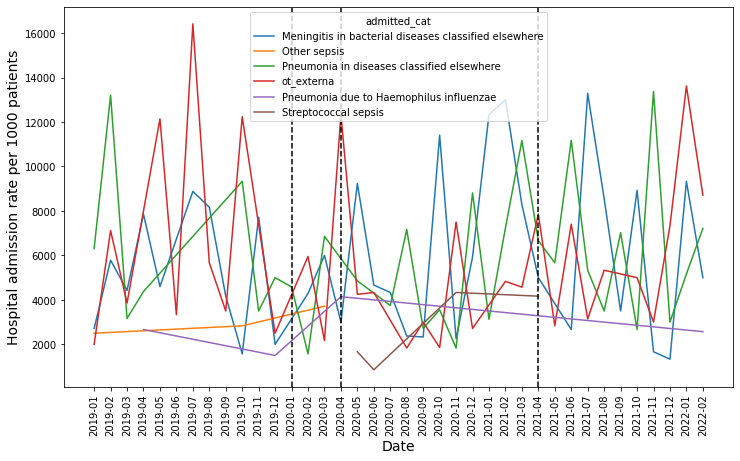

In [198]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_age_cat_groupby_date, y="value_sum", x="date", hue="admitted_cat", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.locator_params(axis='x', nbins=5)
# plt.(np.arange(min(data_hosp_rate_cat_sex_age_cat_groupby_date.date), max(data_hosp_rate_cat_sex_age_cat_groupby_date.date))+1, 1.0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient.jpg')
plt.show()

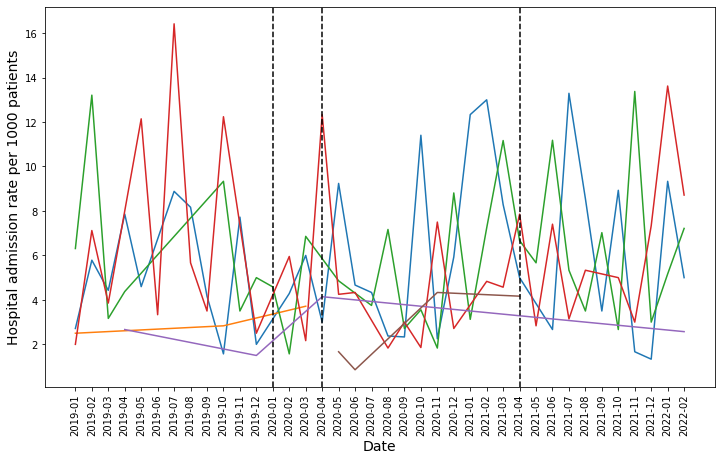

In [167]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_age_cat_groupby_date, y="value_sum", x="date", hue="admitted_cat", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.locator_params(axis='x', nbins=5)
# plt.(np.arange(min(data_hosp_rate_cat_sex_age_cat_groupby_date.date), max(data_hosp_rate_cat_sex_age_cat_groupby_date.date))+1, 1.0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient_nolegend.jpg')
plt.show()

## 4- Hospital admission rate with GP consultation

In [54]:
data_hosp_rate_sex_age_cat_gp.head()

,sex,age_cat,gp_count_admitted_binary,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0-4,0,0,59.0,21.0,2.809524,2019-01-01
1,F,0-4,0,1,24.0,7.0,3.428571,2019-01-01
2,F,0-4,1,0,70.0,25.0,2.800000,2019-01-01
3,F,0-4,1,1,NaN,NaN,NaN,2019-01-01
4,F,15-24,0,0,77.0,26.0,2.961538,2019-01-01


In [55]:
# data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp.groupby([data_hosp_rate_sex_age_cat_gp['date']]).sum()
# data_hosp_rate_sex_age_cat_gp_groupby_date.head()

In [56]:
data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp.groupby(['date', 'gp_cons_admitted_binary']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp_groupby_date.reset_index()
data_hosp_rate_sex_age_cat_gp_groupby_date.columns = ['date', 'gp_cons_admitted_binary', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_sex_age_cat_gp_groupby_date

,date,gp_count_admitted_binary,value_mean,value_min,value_max,value_sum
0,2019-01-01,0,3.422985,2.545455,4.760000,68.459705
1,2019-01-01,1,3.212910,1.333333,5.387097,64.258208
2,2019-02-01,0,3.350431,1.833333,5.571429,67.008623
3,2019-02-01,1,3.120521,1.863636,4.450000,59.289905
4,2019-03-01,0,3.310441,1.769231,4.833333,62.898379
...,...,...,...,...,...,...
71,2021-12-01,1,3.222384,1.750000,5.185185,64.447681
72,2022-01-01,0,3.177662,2.192308,4.095238,57.197907
73,2022-01-01,1,3.197511,2.260870,4.722222,63.950228
74,2022-02-01,0,3.296561,2.090909,5.277778,59.338100


In [57]:
# data_hosp_rate_sex_age_cat_gp_groupby_date['date'] = data_hosp_rate_sex_age_cat_gp_groupby_date.index

data_hosp_rate_sex_age_cat_gp_groupby_date.date = pd.to_datetime(data_hosp_rate_sex_age_cat_gp_groupby_date.date)

data_hosp_rate_sex_age_cat_gp_groupby_date.date = data_hosp_rate_sex_age_cat_gp_groupby_date.date.dt.strftime('%Y-%m')

# data_hosp_rate_sex_age_cat_gp_groupby_date.index = data_hosp_rate_sex_age_cat_gp_groupby_date.date

# data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp_groupby_date.drop(columns=['date'])

data_hosp_rate_sex_age_cat_gp_groupby_date.head()

,date,gp_count_admitted_binary,value_mean,value_min,value_max,value_sum
0,2019-01,0,3.422985,2.545455,4.760000,68.459705
1,2019-01,1,3.212910,1.333333,5.387097,64.258208
2,2019-02,0,3.350431,1.833333,5.571429,67.008623
3,2019-02,1,3.120521,1.863636,4.450000,59.289905
4,2019-03,0,3.310441,1.769231,4.833333,62.898379


In [58]:
data_hosp_rate_sex_age_cat_gp_groupby_date['value_sum'] = data_hosp_rate_sex_age_cat_gp_groupby_date['value_sum']*1000

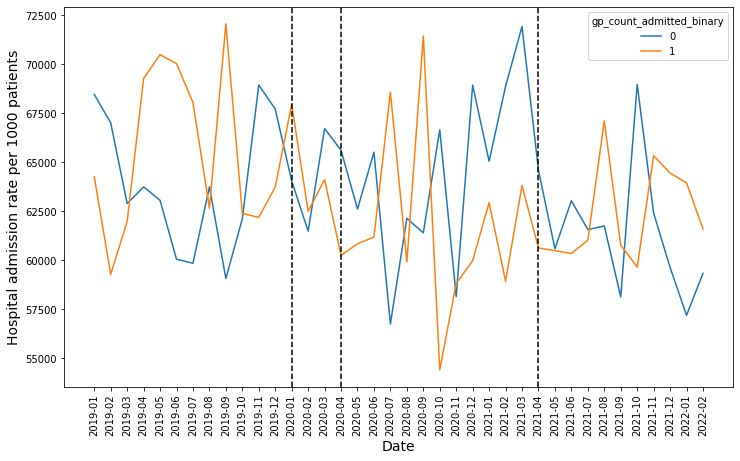

In [59]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_sex_age_cat_gp_groupby_date, y="value_sum", x="date", hue="gp_cons_admitted_binary", ax=ax1)

plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient.jpg')
plt.show()

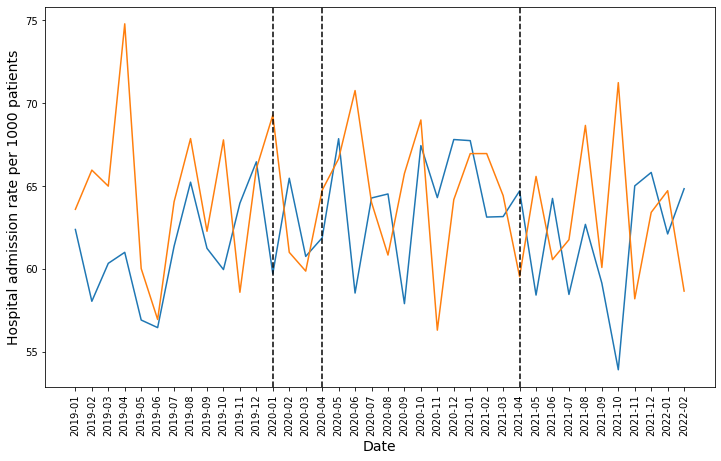

In [181]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_sex_age_cat_gp_groupby_date, y="value_sum", x="date", hue="gp_cons_admitted_binary", ax=ax1)

plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient_nolegend.jpg')
plt.show()